# 第五个数据集：FTD_90_120

来自Dr.SheN贴心的注释：

每次训练的时候，请在上方选择：Kernel-Restart and Run All哦，不然可能出现一些小问题

默认算法：线性回归

默认数据集：PPMI

默认training set：validation set：test set = 8：1：1

默认优化算法：SGD

默认loss：MSELoss（如果是深度方法，由于是二分类问题，建议改成BCE Loss）

这份代码默认实现的是线性回归的训练代码，如果要改成深度方法的代码，要注意outputs = net(inputs)的前向传播的维度和输出。

需要增加的东西：
- K-fold
- 可以尝试PCA降维

## 数据集探索

In [42]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
import PIL
warnings.filterwarnings("ignore")

In [43]:
data = sio.loadmat('FTD_90_200_fMRI.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 15 16:13:18 2021',
 '__version__': '1.0',
 '__globals__': [],
 'FTD': array([[[ 2.50049135,  2.48836375,  0.76244127, ...,  1.58452119,
           2.1307843 ,  2.38140009],
         [ 2.45768574,  2.41266857, -0.78422818, ...,  2.03407663,
           2.03950974,  2.64254884],
         [-1.64347569, -0.44281807, -1.44156423, ...,  1.48753878,
           2.09132309,  2.80178515],
         ...,
         [ 0.70175193, -0.33569285, -0.08657972, ...,  1.94723672,
           1.99002767,  2.97593009],
         [-0.8417131 , -0.32816934,  0.30816443, ...,  1.11815507,
           1.74715135,  2.90560077],
         [-0.60596173, -0.65205069, -0.38014939, ...,  2.07912456,
           2.80800418,  3.82354762]],
 
        [[-3.21530128,  0.74852721, -0.94472378, ...,  3.17270744,
           3.55779983,  0.58324881],
         [-8.56478122, -2.44259909, -0.91971577, ...,  0.88943393,
           2.2078903 , -1.95835273],
     

In [44]:
x_positive = data['NC']
x_negative = data['FTD']
# x_fake_positive = data['EMCI']
# x_fake_negative = data['LMCI']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
# y_fake_positive = np.ones(x_fake_positive.shape[0])
# y_fake_negative = np.zeros(x_negative.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('没有加伪样本的时候有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = np.prod(x_positive.shape[1]**2)
# num_x_fake_pos = x_fake_positive.shape[0]
# num_x_fake_neg = x_fake_negative.shape[0]
# x_total_faked = np.concatenate((x_positive, x_fake_positive, x_fake_negative, x_negative), axis=0).astype(np.float)
# y_total_faked = np.concatenate((y_positive, y_fake_positive, y_fake_negative, y_negative), axis=0).astype(np.float)
# num_fake_total = x_total_faked.shape[0]
num_total = x_total.shape[0]
# print('加了伪样本之后有{}个正样本，有{}个负样本，一共有{}个样本'.format(num_x_fake_pos+num_x_pos, num_x_fake_neg+num_x_neg, num_fake_total))
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

没有加伪样本的时候有86个正样本，有95个负样本，一共有181个样本
(86, 90, 200) (95, 90, 200) (181, 90, 200) (86,) 95 86 8100


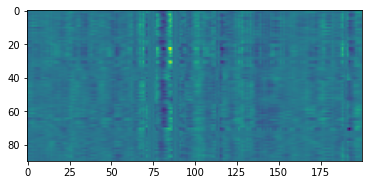

In [45]:
# x_total_faked
plt.imshow(x_total[7, :, :])

## 利用TSNE和PCA的可视化，发现几乎不具有线性可分性

In [5]:
# x_tsne = TSNE(n_components=2).fit_transform(x_total.reshape(num_total, -1))
# print(x_tsne.shape)

In [6]:
# plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = list(y_total))

In [7]:
# x_pca = PCA(n_components=2).fit_transform(x_total.reshape(num_total, -1))
# print(x_pca.shape)

In [8]:
# plt.scatter(x_pca[:, 0], x_pca[:, 1], c = list(y_total))

## 数据预处理（划分train/test dataset和载入dataloader）

### 数据预处理第一步，计算相关系数，并flatten

(181, 90, 200)
(181, 4005)


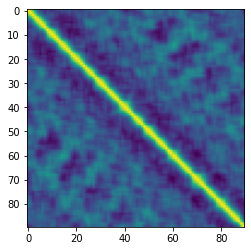

In [50]:
import torch
def corrcoef(input):
    """传入一个tensor格式的矩阵x(x.shape(m,n))，输出其相关系数矩阵"""
    output = []
    for index, x in enumerate(input):
        f = (x.shape[0] - 1) / x.shape[0]      # 方差调整系数
        x_reducemean = x - np.mean(x, axis=0)
        numerator = np.matmul(x_reducemean.T, x_reducemean) / x.shape[0]
        var_ = x.var(axis=0).reshape(x.shape[1], 1)
        denominator = np.sqrt(np.matmul(var_, var_.T)) * f
        output.append(numerator / denominator)
    return output
# pearson = corrcoef(x_total.reshape(181, 200, 90))
print(x_total.shape)
pearson = corrcoef(x_total[:, :, 10: 190].reshape((181, 180, 90)))

pearson = np.array(pearson)
plt.imshow(pearson[0])
pearson_cutted = np.zeros((181, 45*89))
dim_pearson = 90
t = 0
for k in range(pearson.shape[0]):
    for i in range(dim_pearson):
        for j in range(dim_pearson):
            if i < j:
                pearson_cutted[k, t] = pearson[k, i, j]
                t = t + 1
        
    t = 0
pearson_cutted = np.array(pearson_cutted)
print(pearson_cutted.shape)

In [51]:
print(sum(sum(pearson_cutted>1)))

0


### 数据预处理第二步，划分t/t dataset和载入dataloader

In [52]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import random
random.seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
################# batch_size也是一个超参数，第一个调整的参数就是batch_size,可选：1，2，4，8，16，32。
batch_size = 2
kfold = 10
dim_input = 4005

meta_size = int(0.1*x_total.shape[0])
# train_size = int(0.8*x_total.shape[0])
# test_size = int(0.9*x_total.shape[0])
x_total = pearson_cutted
# x_train = []
# y_train = []
# x_val = []
# y_val = []
# x_test = []
# y_test = []
# for i in range(kfold):
#     x_train.append(mixed[meta_size * i: meta_size * (i+1), :dim_input])
    

# x_total = pearson_cutted
# mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
# random.shuffle(mixed)


# print(mixed)
# x_train = mixed[:train_size, :dim_input]
# y_train = mixed[:train_size, dim_input:]
# print(x_train.shape, y_train.shape)
# x_val = mixed[train_size:test_size, :dim_input]
# y_val = mixed[train_size:test_size, dim_input:]
# print(x_val.shape, y_val.shape)
# x_test = mixed[test_size:, :dim_input]
# y_test = mixed[test_size:, dim_input:]
# print(x_test.shape, y_test.shape)

# transform = transforms.Compose([
#     transforms.Normalize(0.5, 0.5)
# ])
# train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
# # print(train_data[0][0].dtype)
# val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
# test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
# train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
# val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
# test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)
# total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
# print(len(train_data), len(val_data), len(test_data))
print(device)

cuda


下面只需要用train_loader作为迭代器，用x_val,y_val（迭代器val_loader）来调参，当在x_val和y_val上达到最优的时候，在x_test(test_loader)上测试一次，作为一个算法的最终结果

In [53]:
# ########### 用于eval，非必要不改动
# ########### 敏感性即召回率，true positive rate = TP/(TP+FN)
# ########### 特异度为true negative rate = TN/(FP+TN)
# def evaluate_accuracy(loader, net):
#     net.eval()
#     sum_all = 0
#     sum_acc = 0
#     FN = 0
#     TN = 0
#     TP = 0
#     FP = 0
    
#     for index, (data, label) in enumerate(loader):
#         with torch.no_grad():
#             data = Variable(data, requires_grad=True).to(device)
#             label = Variable(label, requires_grad=True).to(device)
#         outputs = (net(data) > 0.5).type(torch.float)
# #         print(outputs.shape, label.shape)
#         sum_acc += torch.sum(outputs.argmax(0) == label)
#         for i in range(outputs.shape[0]):
#             if outputs[i, 0] == label[i] and label[i] == 1:
#                 TP += 1
#             elif outputs[i, 0] == label[i] and label[i] == 0:
#                 TN += 1
#             elif outputs[i, 0] != label[i] and label[i] == 1:
#                 FN += 1
#             else:
#                 FP += 1
#         sum_all += data.shape[0]
# #     print('\t\t\ttotal validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
#     acc = sum_acc / sum_all
#     net.train()
#     if (TP + FN) == 0:
#         sensitivity = 0
#     else:
#         sensitivity = TP / (TP + FN)
#     if (FP + TN) == 0:
#         specificity = 0
#     else:
#         specificity = TN / (FP + TN)
#     return acc, sensitivity, specificity

In [54]:
########### 用于eval，非必要不改动
########### 敏感性即召回率，true positive rate = TP/(TP+FN)
########### 特异度为true negative rate = TN/(FP+TN)
def evaluate_accuracy(loader, net):
    if isinstance(net, list):
        net[0].eval()
        net[1].eval()
    else:
        net.eval()
    sum_all = 0
    sum_acc = 0
    FN = 0
    TN = 0
    TP = 0
    FP = 0
    
    for index, (data, label) in enumerate(loader):
        with torch.no_grad():
            data = Variable(data, requires_grad=False).to(device)
            label = Variable(label, requires_grad=False).to(device)
        outputs = net(data).argmax(1).reshape(data.shape[0])
#         print(outputs.shape, label.shape)
        sum_acc += torch.sum(outputs == label.reshape(data.shape[0]))
        label = label.reshape(data.shape[0])
        for i in range(outputs.shape[0]):
            if outputs[i] == label[i] and label[i] == 1:
                TP += 1
            elif outputs[i] == label[i] and label[i] == 0:
                TN += 1
            elif outputs[i] != label[i] and label[i] == 1:
                FN += 1
            else:
                FP += 1
        sum_all += data.shape[0]
#     print('\t\t\ttotal validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
    acc = sum_acc / sum_all
    if isinstance(net, list):
        net[0].train()
        net[1].train()
    else:
        net.train()
    if (TP + FN) == 0:
        sensitivity = 0
    else:
        sensitivity = TP / (TP + FN)
    if (FP + TN) == 0:
        specificity = 0
    else:
        specificity = TN / (FP + TN)
    return acc, sensitivity, specificity

## 实现算法一（传统方法）

In [55]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
# class xxxx(nn.Module):
#     def __init__(self, n_feature):
#         super(xxxx, self).__init__()
#         self.linear = nn.Linear(n_feature, 1)
    
#         self.init_weights()

#     def init_weights(self):
#         """Xavier initialization for the fully connected layer
#         """
#         self.linear.weight.data.uniform_(-1, 1)
#         self.linear.bias.data.fill_(0)

#     def forward(self, x):
#         y = self.linear(x)
#         return torch.sigmoid(y)
    
# # net = LinearNet(dim_input).to(device)
# # print(net) # 使用print可以打印出网络的结构

### SVM的evaluate代码

In [56]:
# def evaluate_svm(x_val, net):
#     score = clf.score(x_val, y_val)
#     pred = clf.predict(x_val)
#     FN = 0
#     TN = 0
#     TP = 0
#     FP = 0
# #     sum_acc += np.sum(clf.predict(x_val) == y_val.reshape(x_val.shape[0]))
#     for i in range(pred.shape[0]):
#         if pred[i] == y_val[i, 0] and y_val[i, 0] == 1:
#             TP += 1
#         elif pred[i] == y_val[i, 0] and y_val[i, 0] == 0:
#             TN += 1
#         elif pred[i] != y_val[i, 0] and y_val[i, 0] == 1:
#             FN += 1
#         else:
#             FP += 1
#     if (TP + FN) == 0:
#         sensitivity = 0
#     else:
#         sensitivity = TP / (TP + FN)
#     if (FP + TN) == 0:
#         specificity = 0
#     else:
#         specificity = TN / (FP + TN)
        
#     return score, sensitivity, specificity

### SVM训练过程代码

In [57]:
# import time
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# import sklearn.metrics as metrics
# var_list = [0.1, 0.5, 1, 1.5, 5, 10]
# # kernel_list = ['rbf','linear', 'poly', 'sigmoid']
# for var in var_list:
#     avg_sen = 0
#     avg_spe = 0
#     avg_score = 0
#     roc_auc = dict()
#     fpr = dict()
#     tpr = dict()
#     print('var of SVM:{}'.format(var))
#     for j in range(100):
#         random.seed(j+1)
#         mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
#         random.shuffle(mixed)
#         kfold = 10
#         GTlist = None
#         Problist = None
#     #     scores = []
#     #     avg_score = 0
#         for i in range(kfold):
#             clf = SVC(kernel = 'rbf', gamma=var, probability = True)
#             x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
#             y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
#             x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
#             y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
#             clf.fit(x_train, y_train)
#         #     print('predict:{}, true:{}'.format(clf.predict(x_val), y_val))

#             score, sen, spe = evaluate_svm(x_val, clf)
#     #         score = clf.score(x_val, y_val)
#     #         scores.append(score)
#             avg_score += score
#             avg_spe += spe
#             avg_sen += sen
#             if j is 1:
#                 if GTlist is None:
#                     GTlist = y_val
#                 else:
#                     GTlist = np.concatenate((GTlist, y_val), axis = 0)
#                 if Problist is None:
#                     Problist = clf.predict(x_val)
#                 else:
#                     Problist = np.concatenate((Problist, clf.predict_proba(x_val)[:, 1]), axis = 0)
#         if j is 1:
# #             print(GTlist.shape, Problist.shape)
#             fpr, tpr, thresholds = metrics.roc_curve(GTlist.reshape(180), Problist, pos_label=1)
# #             print(fpr.shape)
#             roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
#             print(roc_auc_score(GTlist, Problist))


#             plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
#             plt.legend(loc='lower right')
#             # plt.plot([0, 1], [0, 1], 'r--')
#             plt.xlim([-0.1, 1.1])
#             plt.ylim([-0.1, 1.1])
#             plt.xlabel('False Positive Rate') #横坐标是fpr
#             plt.ylabel('True Positive Rate')  #纵坐标是tpr
#             plt.title('Receiver operating characteristic example')
#             plt.savefig('roc_curve.png')
#             plt.show()
#     #         fpr, tpr, _ = roc_curve(y_val, clf.predict(x_val), pos_label=2)
#     #         roc_auc = auc(fpr, tpr)
#         #     print(scores)
#     print('score:{}'.format(avg_score/(kfold * 100)))
#     print('specificity:{}'.format(avg_spe/(kfold*100)))
#     print('sensitivity:{}'.format(avg_sen/(kfold*100)))
#     print(clf.predict(x_val), y_val)
#     print('\n')

In [58]:
# print(clf.predict(x_val), np.sum(clf.predict(x_val) == y_val.reshape(x_val.shape[0])))
# print(y_val[2, 0])

## 实现算法二（传统方法/深度方法）

In [59]:
##############在class里面定义自己的算法，xxxx是算法的名字。
### GAN based-methods
import torchvision.models as models
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
#         nn.conv1 = 
        resnet18 = models.resnet18(pretrained=True)
        resnet18.fc = nn.Linear(512, 2)
        self.linear1 = nn.Linear(n_feature, 1000)
        self.linear3 = nn.Linear(1000, 100)
#         self.linear4 = resnet18.fc
        self.linear4 = nn.Linear(100, 2)
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.fill_(0)
#         self.linear2.weight.data.uniform_(-1, 1)
#         self.linear2.bias.data.fill_(0)
        self.linear3.weight.data.uniform_(-1, 1)
        self.linear3.bias.data.fill_(0)
        self.linear4.weight.data.uniform_(-1, 1)
        self.linear4.bias.data.fill_(0)

    def forward(self, x):
        out = F.dropout(F.relu((self.linear1(x))))
        out = F.dropout(F.relu(self.linear3(out)))
        out = self.linear4(out)
#         x = self.linear4(x)
        return out
    
# net = LinearNet(dim_input).to(device)
# print(net) # 使用print可以打印出网络的结构

In [66]:
#########  训练过程，可以不动它

class LabelSmoothSoftmaxCEV1(nn.Module):
    '''
    This is the autograd version, you can also try the LabelSmoothSoftmaxCEV2 that uses derived gradients
    '''

    def __init__(self, lb_smooth=0.1, reduction='mean', ignore_index=-100):
        super(LabelSmoothSoftmaxCEV1, self).__init__()
        self.lb_smooth = lb_smooth
        self.reduction = reduction
        self.lb_ignore = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, label):
        '''
        Same usage method as nn.CrossEntropyLoss:
            >>> criteria = LabelSmoothSoftmaxCEV1()
            >>> logits = torch.randn(8, 19, 384, 384) # nchw, float/half
            >>> lbs = torch.randint(0, 19, (8, 384, 384)) # nhw, int64_t
            >>> loss = criteria(logits, lbs)
        '''
        # overcome ignored label
        logits = logits.float() # use fp32 to avoid nan
        with torch.no_grad():
            num_classes = logits.size(1)
            label = label.clone().detach()
            ignore = label.eq(self.lb_ignore)
            n_valid = ignore.eq(0).sum()
            label[ignore] = 0
            lb_pos, lb_neg = 1. - self.lb_smooth, self.lb_smooth / num_classes
            lb_one_hot = torch.empty_like(logits).fill_(
                lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        logs = self.log_softmax(logits)
        loss = -torch.sum(logs * lb_one_hot, dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        if self.reduction == 'sum':
            loss = loss.sum()

        return loss

losses = []
accuracy = []
sensitivity = []
specificity = []
preds = []
labels = []
avg_accuracy = []
print_every = 100
print_loss_total = 0
result = 0
num_seeds = 1
for seed in range(num_seeds):
    random.seed(seed)
    mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
    random.shuffle(mixed)
    kfold = 10
    GTlist = None
    Problist = None
    for i in range(kfold):
        learning_rate = 0.001 # 学习率
        num_epochs = 10 # 训练的epoch
        dim_input = 4005
        ######### 实例化算法对象
        xx = MLP(dim_input).to(device)
        ######### 选择损失函数MSELoss
        criterion = LabelSmoothSoftmaxCEV1().to(device)
        ########### 选择minibatch SGD算法
        learning_rate = 0.0001
        ########## 这里面的xxxx是算法对象的实例化，我们的优化算法固定为SGD，可选momentum和nesterov，lr为超参数需要调优
        optimizer = optim.SGD(xx.parameters(), lr=learning_rate)
        print('fold:{}'.format(i))
        x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
        y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
        x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
        y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
        train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
        # print(train_data[0][0].dtype)
        val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    #     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
        train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
        val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
    #     test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)

        for epoch in range(num_epochs):
            xx.train()
#             print('\tEpoch:{}'.format(epoch+1))
            for index, (data1, label1) in enumerate(train_loader):
                data = Variable(data1, requires_grad=True).to(device)
                label = Variable(label1, requires_grad=True).to(device)
                output = xx(data)
#                 print(output.shape, label.shape)
#                 label = label.squeeze()
        #         label = label.squeeze()
                loss = criterion(output, label.detach().reshape(label.shape[0]).long())

                print_loss_total += loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for i in range(data.shape[0]):
                    preds.append(output[i, int(np.array(label[i].detach().cpu())[0])].detach().cpu())
                    labels.append(label[i].detach().cpu())
                if index % print_every == 0:
                    print_loss_avg = print_loss_total / print_every
                    print('\t\tloss:{}'.format(print_loss_avg))
                    losses.append(print_loss_avg)
                    print_loss_total = 0
            acc, sen, spe = evaluate_accuracy(val_loader, xx)
            accuracy.append(acc)
            sensitivity.append(sen)
            specificity.append(spe)
#             if epoch % 10 == 0:
            print('\tEpoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
            print('\n')
            tacc, _, _ = evaluate_accuracy(train_loader, xx)
            print('training accuracy:{}'.format(tacc))
        acc, sen, spe = evaluate_accuracy(val_loader, xx)
        avg_accuracy.append(acc)
    mean_accuracy = 0
    for i in avg_accuracy:
        mean_accuracy += i
    print('average_accuracy:{}'.format(mean_accuracy / kfold))
    result += mean_accuracy
print('result:{}'.format(result / num_seeds))
total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)

fold:0
		loss:4.49698543548584
	Epoch:1, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Specificity:0


training accuracy:0.7239263653755188
		loss:230.18157958984375
	Epoch:2, Accuracy:0.7777777910232544, Sensitivity:0.7777777777777778, Specificity:0


training accuracy:0.7361962795257568
		loss:188.93017578125
	Epoch:3, Accuracy:0.6111111044883728, Sensitivity:0.6111111111111112, Specificity:0


training accuracy:0.699386477470398
		loss:161.53611755371094
	Epoch:4, Accuracy:0.7222222089767456, Sensitivity:0.7222222222222222, Specificity:0


training accuracy:0.7177913784980774
		loss:108.23553466796875
	Epoch:5, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Specificity:0


training accuracy:0.7607361674308777
		loss:122.02993774414062
	Epoch:6, Accuracy:0.5555555820465088, Sensitivity:0.5555555555555556, Specificity:0


training accuracy:0.6809815764427185
		loss:89.76829528808594
	Epoch:7, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Spe

	Epoch:6, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Specificity:0


training accuracy:0.803680956363678
		loss:88.89733123779297
	Epoch:7, Accuracy:0.6111111044883728, Sensitivity:0.6111111111111112, Specificity:0


training accuracy:0.650306761264801
		loss:97.4472427368164
	Epoch:8, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Specificity:0


training accuracy:0.6625766754150391
		loss:60.69477081298828
	Epoch:9, Accuracy:0.8333333134651184, Sensitivity:0.8333333333333334, Specificity:0


training accuracy:0.6687116622924805
		loss:61.220252990722656
	Epoch:10, Accuracy:0.7777777910232544, Sensitivity:0.7777777777777778, Specificity:0


training accuracy:0.7116564512252808
fold:6
		loss:66.15467071533203
	Epoch:1, Accuracy:0.6111111044883728, Sensitivity:0.7692307692307693, Specificity:0.2


training accuracy:0.7668711543083191
		loss:226.52032470703125
	Epoch:2, Accuracy:0.3888888955116272, Sensitivity:0.5384615384615384, Specificity:0.0


training

total acc: tensor(0.7403, device='cuda:0')
sensitivity:0.8373901098901093, specificity:0.060055555555555536
0.7387728505423865


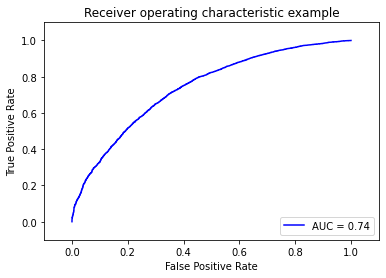

In [65]:
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)
avg_sen = 0
avg_spe = 0
for i, (sen, spe) in enumerate(zip(sensitivity, specificity)):
    avg_sen += sen
    avg_spe += spe 
print('sensitivity:{}, specificity:{}'.format(avg_sen / len(sensitivity), avg_spe / len(specificity)))
# coding=UTF-8
from sklearn import metrics
import matplotlib.pylab as pylab

# 这个GTlist是真实标签
GTlist = labels
# 这个是预测值，
Problist = preds


## 下面的不要改变
fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
print(roc_auc)

pylab.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
pylab.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
pylab.xlim([-0.1, 1.1])
pylab.ylim([-0.1, 1.1])
pylab.xlabel('False Positive Rate') #横坐标是fpr
pylab.ylabel('True Positive Rate')  #纵坐标是tpr
pylab.title('Receiver operating characteristic example')
pylab.show()

## 实现算法三（深度方法）

In [30]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
class Generator(nn.Module):
    def __init__(self,n_input):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(n_input, 256)
        self.linear2 = nn.Linear(256, 1000)
        self.linear3 = nn.Linear(1000, 4005)
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x), inplace=True)
        x = F.leaky_relu(self.linear2(x), inplace=True)
        x = self.linear3(x)
        return F.tanh(x)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(4005, 1000)
        self.linear2 = nn.Linear(1000, 256)
        self.linear3 = nn.Linear(256, 1)
        self.init__weights()
    def init__weights(self):
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.fill_(0)
        self.linear2.weight.data.uniform_(-1, 1)
        self.linear2.bias.data.fill_(0)
        self.linear3.weight.data.uniform_(-1, 1)
        self.linear3.bias.data.fill_(0)
    def forward(self, x):
        x = F.relu(F.dropout(self.linear1(x)))
        x = F.relu(F.dropout(self.linear2(x)))
        x = self.linear3(x)
        return torch.sigmoid(x)

def generate_latent_point(latent_dim, n):
    generator_input = torch.randn(latent_dim*n)
    x_input = generator_input.reshape(n, latent_dim)
    return x_input

def generate_fake_example(generator, latent_dim, n):
    x_input = generate_latent_point(latent_dim, n).to(device)
    X = generator(x_input).to(device)
    y = torch.zeros((n, 1)).to(device)
    return X, y

def summarize_performance(epoch, genrerator, discriminator, latent_dim, n=100):
    return 0

In [31]:
def train_gan(train_loader):
    n_input = 100
    num_epoch = 5
    lr = 1e-2
    generator = Generator(100).to(device)
    discriminator = Discriminator().to(device)
    criterion_gan = nn.BCELoss().to(device)
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = optim.Adam(generator.parameters(), lr=lr)
    generator.train()
    discriminator.train()
    
    for epoch in range(num_epoch):
        for index, (real_samples, labels) in enumerate(train_loader):
            real_x = Variable(real_samples, requires_grad=True).to(device)
            real_y = Variable(torch.ones((real_x.shape[0], 1)), requires_grad=True).to(device)
            fake_x, fake_y = generate_fake_example(generator, n_input, real_x.shape[0])
            fake_y = Variable(fake_y, requires_grad=True).to(device)
            all_x = torch.cat((real_x, fake_x))
            all_y = torch.cat((real_y, fake_y))
            
            discriminator.zero_grad()
            output_d = discriminator(all_x)
            loss_d = criterion_gan(output_d, all_y.detach())
            loss_d.backward()
            optimizer_discriminator.step()
            
            generator.zero_grad()
            fake_x, fake_y = generate_fake_example(generator, n_input, real_x.shape[0])
            output_g = discriminator(fake_x)
            loss_g = criterion_gan(output_g, real_y.detach())
            loss_g.backward()
            optimizer_generator.step()
            
            if index == len(train_loader)-2:
                print(f"Epoch: {epoch} Loss D.: {loss_d}")
                print(f"Epoch: {epoch} Loss G.: {loss_g}")
    
    return generator, discriminator

In [32]:
mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
random.shuffle(mixed)
# x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
# y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
# print(train_data[0][0].dtype)
# val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
#     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
# val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
generator, _ = train_gan(train_loader)

Epoch: 0 Loss D.: 75.0
Epoch: 0 Loss G.: 0.0
Epoch: 1 Loss D.: 75.0
Epoch: 1 Loss G.: 100.0
Epoch: 2 Loss D.: 75.0
Epoch: 2 Loss G.: 50.0
Epoch: 3 Loss D.: 50.0
Epoch: 3 Loss G.: 0.0
Epoch: 4 Loss D.: 50.0
Epoch: 4 Loss G.: 0.0


In [33]:
fake_x, fake_y = generate_fake_example(generator, 100, 2)
print(fake_x)

tensor([[ 1.0000, -1.0000, -1.0000,  ..., -1.0000,  1.0000, -1.0000],
        [ 1.0000, -1.0000, -1.0000,  ..., -1.0000,  1.0000, -1.0000]],
       device='cuda:0', grad_fn=<TanhBackward>)


In [35]:
#########  训练过程，可以不动它


losses = []
accuracy = []
sensitivity = []
specificity = []
preds = []
labels = []
avg_accuracy = []
print_every = 100
print_loss_total = 0
for seed in range(1):
    random.seed(seed)
    mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
    random.shuffle(mixed)
    kfold = 10
    GTlist = None
    Problist = None
    for i in range(kfold):
        learning_rate = 1e-4 # 学习率
        num_epochs = 10 # 训练的epoch
        dim_input = 4005
        ######### 实例化算法对象
        xx = MLP(dim_input).to(device)
        ######### 选择损失函数MSELoss
        optimizer = optim.Adam(xx.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss().to(device)
        ########### 选择minibatch SGD算法
        print('fold:{}'.format(i))
        x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
        y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
        x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
        y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
        train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
        # print(train_data[0][0].dtype)
        val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    #     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
        train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
        val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
    #     test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)
#         generator1 = train_gan(train_1_loader)
# #         generator0 = train_gan(train_0_loader)
#         gan = [generator, discriminator]
        for epoch in range(num_epochs):

#             print('\tEpoch:{}'.format(epoch+1))
            for index, (data1, label1) in enumerate(train_loader):
                data = Variable(data1, requires_grad=True).to(device)
                label = Variable(label1, requires_grad=True).to(device)
                output = xx(data)
#                 print(output.shape, label.shape)
#                 label = label.squeeze()
        #         label = label.squeeze()
                loss = criterion(output, label.detach().reshape(label.shape[0]).long())
                
                fake_x, fake_y = generate_fake_example(generator, 100, 4)
                fake_label = xx(fake_x).argmax(1)
                loss = criterion(xx(fake_x), fake_label.detach().reshape(fake_label.shape[0]).long())
                
                print_loss_total += loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for i in range(data.shape[0]):
                    preds.append(output[i, int(np.array(label[i].detach().cpu())[0])].detach().cpu())
                    labels.append(label[i].detach().cpu())
                if index % print_every == 0:
                    print_loss_avg = print_loss_total / print_every
                    print('\t\tloss:{}'.format(print_loss_avg))
                    losses.append(print_loss_avg)
                    print_loss_total = 0
            acc, sen, spe = evaluate_accuracy(val_loader, xx)
            accuracy.append(acc)
            sensitivity.append(sen)
            specificity.append(spe)
#             if epoch % 10 == 0:
            print('\tEpoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
            print('\n')
            tacc, _, _ = evaluate_accuracy(train_loader, xx)
            print('training accuracy:{}'.format(tacc))
        acc, sen, spe = evaluate_accuracy(val_loader, xx)
        avg_accuracy.append(acc)
    mean_accuracy = 0
    for i in avg_accuracy:
        mean_accuracy += i
    print('average_accuracy:{}'.format(mean_accuracy / kfold))
total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)
avg_sen = 0
avg_spe = 0
for i, (sen, spe) in enumerate(zip(sensitivity, specificity)):
    avg_sen += sen
    avg_spe += spe 
print('sensitivity:{}, specificity:{}'.format(avg_sen / len(sensitivity), avg_spe / len(specificity)))

fold:0
		loss:0.16278411448001862
	Epoch:1, Accuracy:0.4444444477558136, Sensitivity:0.4444444444444444, Specificity:0


training accuracy:0.5766870975494385
		loss:755.7671508789062
	Epoch:2, Accuracy:0.6666666865348816, Sensitivity:0.6666666666666666, Specificity:0


training accuracy:0.5828220844268799
		loss:454.6268310546875
	Epoch:3, Accuracy:0.6111111044883728, Sensitivity:0.6111111111111112, Specificity:0


training accuracy:0.5398772954940796
		loss:443.6789245605469
	Epoch:4, Accuracy:0.6111111044883728, Sensitivity:0.6111111111111112, Specificity:0


training accuracy:0.5214723944664001
		loss:157.74058532714844
	Epoch:5, Accuracy:0.7222222089767456, Sensitivity:0.7222222222222222, Specificity:0


training accuracy:0.558282196521759
		loss:248.5369110107422
	Epoch:6, Accuracy:0.6111111044883728, Sensitivity:0.6111111111111112, Specificity:0


training accuracy:0.6012269854545593
		loss:229.3931427001953
	Epoch:7, Accuracy:0.5555555820465088, Sensitivity:0.5555555555555556, S

training accuracy:0.4907975196838379
		loss:371.55218505859375
	Epoch:7, Accuracy:0.5, Sensitivity:0.5, Specificity:0


training accuracy:0.5644171833992004
		loss:528.2686767578125
	Epoch:8, Accuracy:0.5, Sensitivity:0.5, Specificity:0


training accuracy:0.4417177736759186
		loss:523.158203125
	Epoch:9, Accuracy:0.4444444477558136, Sensitivity:0.4444444444444444, Specificity:0


training accuracy:0.47852760553359985
		loss:470.55902099609375
	Epoch:10, Accuracy:0.5555555820465088, Sensitivity:0.5555555555555556, Specificity:0


training accuracy:0.47239261865615845
fold:6
		loss:352.11724853515625
	Epoch:1, Accuracy:0.5, Sensitivity:0.38461538461538464, Specificity:0.8


training accuracy:0.47239261865615845
		loss:1116.658203125
	Epoch:2, Accuracy:0.4444444477558136, Sensitivity:0.38461538461538464, Specificity:0.6


training accuracy:0.42331287264823914
		loss:1106.3155517578125
	Epoch:3, Accuracy:0.6111111044883728, Sensitivity:0.46153846153846156, Specificity:1.0


training accur

## 训练准备（目标函数、优化方法、超参数）

In [21]:
print(avg_accuracy)

[tensor(0.9444, device='cuda:0'), tensor(0.8889, device='cuda:0'), tensor(0.9444, device='cuda:0'), tensor(0.7778, device='cuda:0'), tensor(0.7222, device='cuda:0'), tensor(0.8333, device='cuda:0'), tensor(0.7778, device='cuda:0'), tensor(0.6667, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.5556, device='cuda:0')]


## 可视化

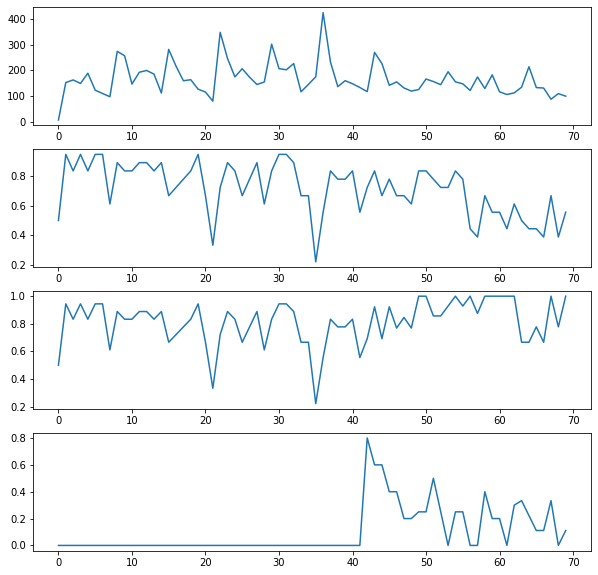

In [29]:
plt_list = [losses, accuracy, sensitivity, specificity]
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(plt_list[i])

## ROC曲线可视化


ROC曲线下的面积为AUC，这个面积（下面打印的结果）如果大于0.5就证明具有一定价值，越接近1越好。如果实验完全随机，那么面积就等于0.5，就相当于p用没有

sensitivity:0.44894078144078164, specificity:0.30361111111111116
0.4683331519798224


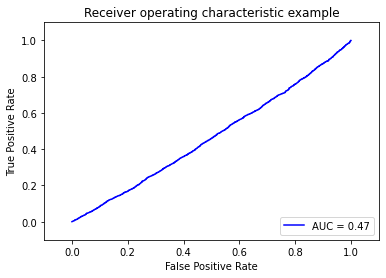

In [37]:
avg_sen = 0
avg_spe = 0
for i, (sen, spe) in enumerate(zip(sensitivity, specificity)):
    avg_sen += sen
    avg_spe += spe 
print('sensitivity:{}, specificity:{}'.format(avg_sen / len(sensitivity), avg_spe / len(specificity)))
# coding=UTF-8
from sklearn import metrics
import matplotlib.pylab as pylab

# 这个GTlist是真实标签
GTlist = labels
# 这个是预测值，
Problist = preds


## 下面的不要改变
fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
print(roc_auc)

pylab.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
pylab.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
pylab.xlim([-0.1, 1.1])
pylab.ylim([-0.1, 1.1])
pylab.xlabel('False Positive Rate') #横坐标是fpr
pylab.ylabel('True Positive Rate')  #纵坐标是tpr
pylab.title('Receiver operating characteristic example')
pylab.show()

## 当所有超参数调整好的时候，在测试集上运行一次，作为最终的accuracy，请记录下来

In [24]:
acc, sen, spe = evaluate_accuracy(test_loader, xx)
print('Accuracy on test set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

NameError: name 'test_loader' is not defined

In [ ]:
acc, sen, spe = evaluate_accuracy(total_loader, xx)
print('Accuracy on total set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))